In [9]:
from scipy.optimize import fsolve
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import random
from numpy.linalg import eig
# from control import matlab
from control import dlqr
# from scipy.signal import place_poles
from scipy.io import savemat
# import pandas as pd

In [10]:
c_in_air = 666000.0
c_itm = 16280000.0
c_in_air = c_itm + c_in_air
r_wall_ex = 0.0005088487328366421
r_wall = 0.004
r_wall_in = 0.0007950761450572532
r_wind =  0.0023
r_in = 0.00033783783783783786
# Q_dot_FCU_AC = -11.62 * 10 * 1000   # Watt
dt=5
h_amb=(1/(r_wall + r_wall_ex + r_wall_in))+(1/r_wind)

In [11]:
def ss(Q_dot):
    # T = p
    e1=(33-25)*h_amb+40000-Q_dot
    return (e1)

u =  fsolve(ss, (1))
print(u)

[44986.57785824]


In [12]:
a = - h_amb/c_in_air
b = - 1/c_in_air
e1 = h_amb/c_in_air
e2 = 1/c_in_air

In [13]:
# Define the LQR system matrices
A_c = np.array([[a]])
B_c = np.array([[b]])
C_c = np.array([[1]])
D = np.array([[0]])
E_c = np.array([[e1, e2]])
print(A_c)
print(B_c)
print(E_c)

[[-3.67828533e-05]]
[[-5.9010976e-08]]
[[3.67828533e-05 5.90109760e-08]]


In [14]:
num_states,num_control_inputs = B_c.shape                                       # Number of states 
num_outputs,num_disturbances = E_c.shape

In [15]:
# Continuous-time to discrete-time conversion (FUNCTION)
from typing import Tuple
import numpy as np
from scipy.linalg import expm
def c2d(
    a_c: np.ndarray, b_c: np.ndarray, sample_period: float
    ) -> Tuple[np.ndarray]:
    """
    Continuous to discrete conversion of A and B given a sample period
    Args:
         a_c (np.ndarray): A matrix
         b_c (np.ndarray): B matrix
         sample_period (float): Sample period
    Returns:
        :obj:`tuple` of :obj:`np.ndarray`: matrix pair (Ad, Bd)
    """
    (n_x, n_u) = b_c.shape
    phi = np.concatenate(
        [np.concatenate([a_c, b_c], axis=1), np.zeros([n_u, n_x + n_u])],
        axis=0,
        )
    phi = expm(phi * sample_period)
    return (phi[:n_x, :n_x], phi[:n_x, n_x:(n_x + n_u)])

In [16]:
# Continuous-time to discrete-time conversion (FUNCTION)
## Exact method discretization 
num_steps = 288 # Number of 5 minute intervals in 24 hrs
sample_period = dt * 60    # in second
A_d = np.zeros((num_states,num_states))
B_d = np.zeros((num_states, num_control_inputs))
E_d = np.zeros((num_states, num_disturbances))
BcEc = np.hstack((B_c, E_c))
BdEd = np.zeros((num_states,num_control_inputs+num_disturbances))
# Get the dimensions of B_c and C_c
# n_x, n_u = B_c.shape
A_d, BdEd  = c2d(A_c , BcEc , sample_period)
# Extract the discrete B_c and C_c from BdCd
B_d [:,:] = BdEd[:, :num_control_inputs]
E_d [:,:] = BdEd[:, num_control_inputs:]
# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(A_d)
# Print the eigenvalues
print("Eigenvalues of matrix A_d are:")
print(eigenvalues)
print ("A_d:")
print (A_d)
print ("B_d:")
print (B_d)
print ("E_d:")
print (E_d)

Eigenvalues of matrix A_d are:
[0.9890258]
A_d:
[[0.9890258]]
B_d:
[[-1.76059745e-05]]
E_d:
[[1.09741953e-02 1.76059745e-05]]


In [17]:
# h_ceil = 4            # (m)
# A_floor = 185          # (m2) (assuming a square 6.32 m by 6.32 m space)
# alpha = 0.35       # absorptivity of walls (Red clay brick)
# SHGC = 0.15       # solar heat gain coefficient of windows
# A_floor = 185          #(m2) (assuming a square 6.32 m by 6.32 m space)
# A_roof = A_floor

In [18]:
# p_solar_total = [0]*num_steps
# for i in range(num_steps):
#     p_solar_total [i] = 40000

In [19]:
Q = np.array([[10**7]])
R = np.array([[10**-2]])                   # Control cost matrix

In [20]:
K, S, V = dlqr(A_d, B_d, Q, R)
At = np.array([[1]])
w,v=eig(A_d-B_d@K@At)
print(K)
print(S)
print(abs(w))

[[-23499.39552587]]
[[23200921.43673241]]
[0.57529605]


In [21]:
##### Define the decision variables and control inputs
tot_time = num_steps
x0 = np.array([[0.0]])
cost1=0

In [22]:
##### Store the states, outputs and controls for plotting (I have replaced tot_time with num_steps for the building model)

states = np.zeros((num_states, tot_time+1))
output = np.zeros((num_outputs, tot_time+1))
controls = np.zeros((num_control_inputs, tot_time+1))
controls_ss = np.zeros((num_control_inputs, tot_time+1))
tot_cost_MPC = np.zeros((tot_time+1))
dist_MPC = np.zeros([2,tot_time+1])
noise_MPC = np.zeros([1,tot_time+1])
norm = np.zeros((num_states, tot_time+1))

In [23]:
### Disturbance bounds (change name)
alpha1 = 5
alpha2 = 1000
alpha3 = 0.5

In [24]:
##### Closed-loop MPC    
random.seed(0)
for n in range(tot_time):
    print('Time step:',n)
    mpc = Model()
    
    x_var = np.array([[mpc.continuous_var(name=f"x_var{i}_{j}",lb=-mpc.infinity, ub=mpc.infinity) for j in range(num_steps+1)] for i in range(num_states)])
    u_var = np.array([[mpc.continuous_var(name=f"u_var{i}_{j}",lb=-mpc.infinity) for j in range(num_steps)] for i in range(num_control_inputs)])

    #### Open-loop MPC

    
    ### Add the state space equations as contraints
    for i in range(num_steps):
        for m in range (num_states):
            ## Create the state space equations
            state_eq = mpc.sum(A_d[m, j] * x_var[j, i] for j in range(num_states))
            control_eq = mpc.sum(B_d[m, k] * u_var[k, i] for k in range(num_control_inputs))

            ## Add the constraint for the current time step
            mpc.add_constraint(x_var[m, i + 1] == state_eq + control_eq)

    #### Define disturbances and noise
    
    dist_1=random.uniform(-alpha1, alpha1)                                                  # Disturbance in state 1
    dist_2=random.uniform(-alpha2, alpha2)                                            # Disturbance in state 2
    noise_1=random.uniform(-alpha3, alpha3)
    d=[[dist_1],[dist_2]]
    noise=[[noise_1]]
    dist_MPC[:,n] = [dist_1,dist_2]
    noise_MPC[:,n]=[noise_1]

    ### Initial condition
    y0 = At @ (C_c @ x0+noise)
    mpc.add_constraint(x_var[0,0] == y0[0,0])

    ### Create the objective expression 
    J = []
    for i in range(num_steps):
        state_cost = 0
        input_cost = 0
        for m in range(num_states):
            state_cost += mpc.sum((x_var[m,i]) * Q[m,j] * (x_var[j,i]) for j in range(num_states))
        for m in range(num_control_inputs):
            input_cost += mpc.sum((u_var[m,i]) * R[m,j] * (u_var[j,i]) for j in range(num_control_inputs))
        J.append(state_cost + input_cost) 

    ### Terminal cost calculation
    terminal_cost = 0
    for m in range(num_states):
        terminal_cost += mpc.sum(x_var[m, num_steps] * S[m, j] * x_var[j, num_steps] for j in range(num_states))
    J.append(terminal_cost)
      

    ### Set the objective sense and expression in the model
    objective = mpc.sum(J[j]   for j in range(num_steps))
    # print(objective)
    mpc.set_objective("minimize", objective)
    mpc.parameters.barrier.qcpconvergetol = 5*10**(-10)  # Increase MIP gap tolerance
    ### Solve the model
    solution_tot = mpc.solve()
    # mpc.print_information()
    print(mpc.solve_details)
    # print(solution_tot)

    # Check if the solution was successful (non-empty)
    if not solution_tot:
        n=n-2
    # if the optimization is infeasible, the loop will break. After the break the x0 value assigned in states will have no use as that is already done. Also, in plotting only n-1 states willbe printed
        print("Solution not found. Exiting loop.")
        break
       
    ### Extract the values for X and U from the solution
    X_values = np.array([[solution_tot[x_var[k, j]] for j in range(num_steps+1)] for k in range(num_states)])
    U_values = np.array([[solution_tot[u_var[k, j]] for j in range(num_steps)] for k in range(num_control_inputs)])
    
    ### Calculating the optimized objective cost
    opt_cost = [solution_tot[objective]]
    cost=0
    input_cost_1=0
    state_cost_1=0
    x = np.zeros((1,num_steps+1))
    for i in range(num_states):
        x[i,0] = y0[i,0]
    for j in range(num_steps):
        x[:,j+1] = A_d @ X_values[:,j] + B_d @ U_values[:,j] 
        cost += X_values[:,j].T @ Q @ X_values[:,j] + U_values[:,j].T @ R @ U_values[:,j]
    #     state_cost_1 += X_values[:,j].T @ Q @ X_values[:,j]
    #     input_cost_1 += U_values[:,j].T @ R @ U_values[:,j]
    # cost+=X_values[:,num_steps].T @ Q @ X_values[:,num_steps]
    
    
    

    ### Store values of closed-loop state and trajectories

    u_mpc = np.array([[U_values[k,0]] for k in range(num_control_inputs)])
    for j in range(num_states):
        states[j, n] = x0[j,:]                                                            # Store closed-loop states for Q
        output[j, n] = y0[j,:]
        print('State:',states[j,n])
    for j in range(num_control_inputs):
        controls[j, n] = (u_mpc[j,:])                                                     # Store closed-loop inputs for Q
        print('Controls:',controls[j, n])    

    tot_cost_MPC[n] = states[:,n].T @ Q @ states[:,n] + controls[:,n].T @ R @ controls[:,n]
    # cost1 += x0.T @ Q @ x0 + u_mpc.T @ R @ u_mpc
    x0 = A_d @ x0 + B_d @ u_mpc +E_d @ d                                                    # Optimal initial state for the next iteration of open-loop simulation
    # x0 = A_d @ x0 + B_d @ u_mpc                                                   # Optimal initial state for the next iteration of open-loop simulation
    # print('Optimized Cost:',tot_cost_MPC[n])
print(n)
noise_1=random.uniform(-alpha3, alpha3)
noise=[[noise_1]]
y0 = At @ (C_c @ x0 + noise)
if n==tot_time-1:
    for j in range(num_states):
        states[j, n+1] = x0[j,:]
        output[j, n+1] = y0[j,:]
    controls[0,n+1] = (controls[0,n]) 
    # tot_cost_MPC[n+1] = tot_cost_MPC[n]
    dist_MPC[:,n+1] = dist_MPC[:,n]
    noise_MPC[:,n+1] = noise_MPC[:,n]

Time step: 0
status  = optimal
time    = 0.016 s.
problem = QP

State: 0.0
Controls: -1866.5198380502502
Time step: 1
status  = optimal
time    = 0 s.
problem = QP

State: 0.07974250451850962
Controls: -360.08965115671253
Time step: 2
status  = optimal
time    = 0.016 s.
problem = QP

State: 0.05914718214849418
Controls: 839.9655966641388
Time step: 3
status  = optimal
time    = 0.016 s.
problem = QP

State: 0.06792854576134368
Controls: 1706.4180429682633
Time step: 4
status  = optimal
time    = 0 s.
problem = QP

State: 0.0606608900734886
Controls: 4207.094119661524
Time step: 5
status  = optimal
time    = 0 s.
problem = QP

State: -0.029008982476476444
Controls: 10663.47330253468
Time step: 6
status  = optimal
time    = 0.015 s.
problem = QP

State: -0.22938342801607392
Controls: -9851.789262140794
Time step: 7
status  = optimal
time    = 0 s.
problem = QP

State: -0.00521088706717153
Controls: 4201.058490252872
Time step: 8
status  = optimal
time    = 0 s.
problem = QP

State: -0.0

In [25]:
# anomaly_detected = False  # Initialize a flag variable
# print(tot_time)
# for i in range(tot_time):
#     if abs(output[0,i])  >= 1.099 : #2.7797
#         print("Anamoly detected at time step",i)
#         anomaly_detected = True  # Set the flag to True
#         # break
    
# if not anomaly_detected:
#     print("No anomaly observed")

In [26]:
x0 = np.array([[0.0]])
# cost1=0

In [27]:
random.seed(0)

# Disturbance array initialization
# dist_linear=np.zeros([4,num_steps+1])

# Initialization of ans(X[0],X[1])
states_linear = np.zeros([num_states,num_steps+1])
output_linear = np.zeros([num_states,num_steps+1])
controls_linear = np.zeros([num_control_inputs,num_steps+1])
dist_linear = np.zeros([3,tot_time+1])
# rate_linear = np.zeros((tot_time+1))
tot_cost_linear = np.zeros((tot_time+1))
for i in range(num_states):
    states_linear[i,0] = x0[i]


for m in range(tot_time):       
    X = np.array([[states_linear[0,m]]])
#     X = np.array([[states_linear[0,m]],[states_linear[1,m]]])         
    dist_1=random.uniform(-alpha1, alpha1)                                                  # Disturbance in state 1
    dist_2=random.uniform(-alpha2, alpha2)                                            # Disturbance in state 2
    d=[[dist_1],[dist_2]]
    noise_1=random.uniform(-alpha3, alpha3)
    noise = [[noise_1]]
    dist_linear[:,m] = [dist_1,dist_2,noise_1]
    Y = At@(C_c@X+noise)
    U = - (K@Y)
    print(m)
    X_new = np.zeros([1,1]) 
    # X_new = A_d@X+B_d@U
    X_new = A_d@X+B_d@U+E_d@d
    states_linear[:,m+1] = X_new 
    output_linear[:,m] = Y 
        # print('State:',states_linear[i,m])
    controls_linear[:,m] = U 
    print(U)
    tot_cost_linear[m] = states_linear[:,m].T @ Q @ states_linear[:,m] + controls_linear[:,m].T @ R @ controls_linear[:,m]
#     # tot_cost_linear[m] =  controls_linear[:,m].T @ R @ controls_linear[:,m]


if m==tot_time-1:
    noise_1=random.uniform(-alpha3, alpha3)
    noise = [[noise_1]]
    controls_linear[:,m+1]=controls_linear[:,m]
    # tot_cost_linear[m+1] = tot_cost_linear[m]
    # dist_linear[:,m+1] = dist_linear[:,m]
    Y = At@(C_c@X + noise)
    output_linear[:,m+1] = Y  


0
[[-1866.51983805]]
1
[[-360.08965116]]
2
[[839.96559666]]
3
[[1706.41804297]]
4
[[4207.09411966]]
5
[[10663.47330253]]
6
[[-9851.78926214]]
7
[[4201.05849025]]
8
[[-2483.40522644]]
9
[[10663.97634338]]
10
[[-9710.26542106]]
11
[[-11196.49320192]]
12
[[13313.6899919]]
13
[[441.37995472]]
14
[[-3683.54654986]]
15
[[4265.94235386]]
16
[[8709.43008967]]
17
[[-6551.66034399]]
18
[[-9255.18994489]]
19
[[5255.07431989]]
20
[[13123.68333306]]
21
[[-3678.72694983]]
22
[[1278.53589658]]
23
[[-8231.3021542]]
24
[[1196.20629534]]
25
[[10507.96049286]]
26
[[5800.67134679]]
27
[[-7096.30144175]]
28
[[6891.72510915]]
29
[[-823.92012544]]
30
[[-2494.6926091]]
31
[[10737.49711129]]
32
[[-38.88325116]]
33
[[5876.37324082]]
34
[[-13563.84879194]]
35
[[-3311.28090877]]
36
[[-6800.35636771]]
37
[[6526.96884795]]
38
[[6415.38310426]]
39
[[3078.14446108]]
40
[[-4861.13408049]]
41
[[-10913.84745551]]
42
[[-3143.46749158]]
43
[[18129.59699874]]
44
[[-9587.97071779]]
45
[[5906.25112099]]
46
[[-781.61454284]]


In [28]:
# for m in range(tot_time+1):
#     for i in range(num_states):
#         states_linear[i,m] = states_linear[i,m]
#         output_linear[i,m] = output_linear[i,m]
#     controls_ss[:,m] = u[0]

In [29]:
# savemat('building_data_no_attack_test.mat', {'states_test': states,'output_test': output, 'controls_test': controls, 'output_linear': output_linear, 'states_linear': states_linear, 'controls_linear': controls_linear, 'controls_ss': controls_ss, 'disturbances_test': dist_MPC, 'noise_test': noise_MPC})

In [30]:
savemat('building_data_no_attack.mat', {'states': states,'output': output, 'controls': controls, 'output_linear': output_linear, 'states_linear': states_linear, 'controls_linear': controls_linear, 'controls_ss': controls_ss, 'disturbances': dist_MPC, 'noise': noise_MPC})

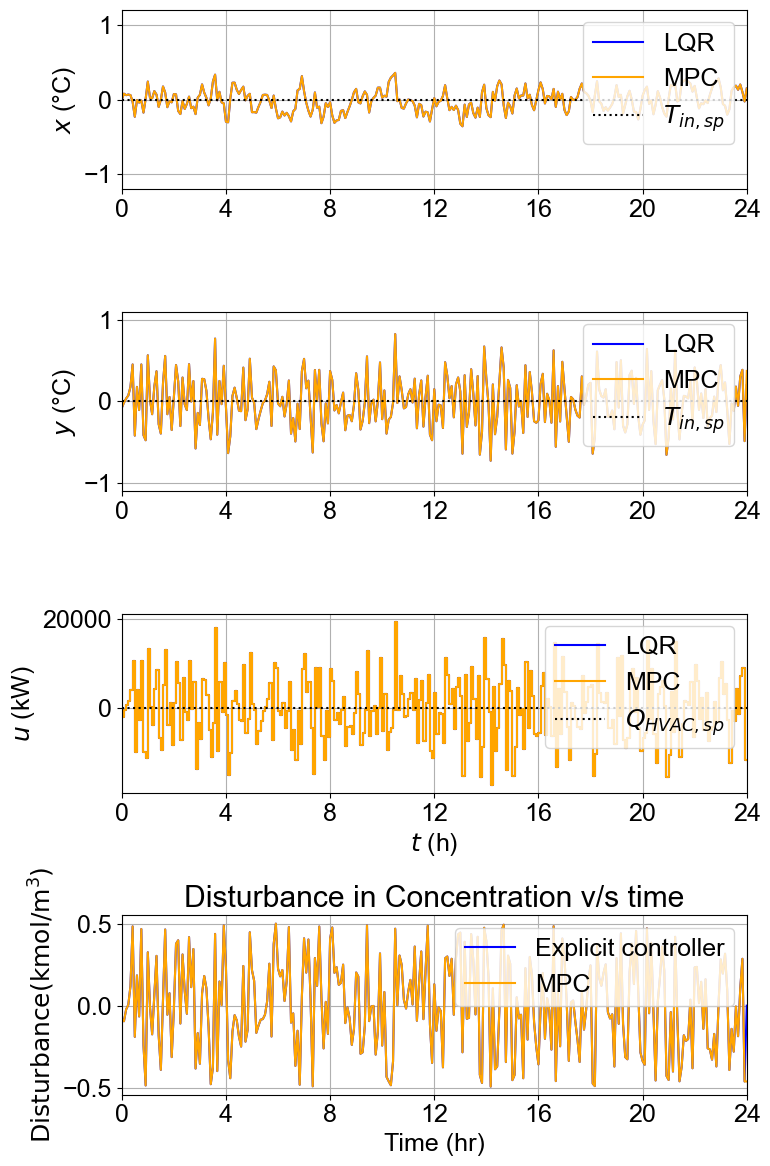

In [31]:
# Plot the results

time_steps = np.arange(num_steps+1) /12
# print(np.shape(controls))
# Define time range
# tz='US/Pacific'
# start = pd.Timestamp('2023-06-21 00:00:00', tz=tz)
# end = pd.Timestamp('2023-06-22 00:00:00', tz=tz)
# time_index = pd.date_range(start, end, freq='5min')

# # Calculate the time difference (dt) between consecutive timestamps in minutes
# dt = (time_index[1] - time_index[0]).total_seconds() / 60   # in minutes
# #print(dt)
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'Arial'
# time_steps = np.array(time_index)
fig = plt.figure()

fig.set_figheight(12)
fig.set_figwidth(8)

ax = fig.add_subplot(4, 1, 1)
ax.plot(time_steps[:tot_time+1], states_linear[0,:tot_time+1], label='LQR', color = 'blue') #+25
ax.plot(time_steps[:tot_time+1], states[0,:tot_time+1], label='MPC',color='orange') #+25
plt.axhline(0, color='black', label=r'$T_{in,sp}$',linestyle='dotted')
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('State')
# ax.set_ylim([23.5,26.5])
ax.set_ylim([-1.2,1.2])
# ytick_loc = [40,44,48]
# ax.set_ylabel('Actual temperature (°C)')
ax.set_ylabel(r'$x$'' (°C)')


# ax.set_title('State v/s time')
# ax.set_ylim([24.8,25.3])
ax.legend(loc='upper right')

# ax = fig.add_subplot(4, 2, 3)
# # ax.plot(time_steps[:m+2], states_linear[1, :m+2], label='Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], states[1, :n+2], label='MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Temperature (K)')
# ax.set_title('State 2 v/s time')
# ax.legend()

ax = fig.add_subplot(4, 1, 2)
ax.plot(time_steps[:tot_time+1], output_linear[0,:tot_time+1], label='LQR', color = 'blue')
ax.plot(time_steps[:tot_time+1], output[0,:tot_time+1], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$T_{in,sp}$',linestyle='dotted')
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Output')
# ax.set_title('Output  v/s time')
# ax.set_ylim([23.5,26.5])
ax.set_ylim([-1.1,1.1])
# ax.set_ylabel('Measured temperature (°C)')
ax.set_ylabel(r'$y$'' (°C)')

# ax.set_title('Output 1 v/s time')
ax.legend(loc='upper right')

ax = fig.add_subplot(4, 1, 3)
ax.step(time_steps[:tot_time+1], controls_linear[0, :tot_time+1], where = 'post', label = 'LQR', color = 'blue')
ax.step(time_steps[:tot_time+1], controls[0, :tot_time+1], where = 'post', label = 'MPC',color='orange')
plt.axhline(0, color='black', label=r'$Q_{HVAC,sp}$',linestyle='dotted')
# ax.step(time_steps[:n+2], controls_ss[0, :n+2], where = 'post', label = 'Steady state rate',color='red')
ax.set_xlabel(r'$t$ (h)')
# ax.set_ylabel('Control Input')
ax.set_ylabel(r'$u$ (kW)')
# ax.set_title('Input v/s time')
# ax.set_ylim([-50,50])
# # ytick_loc = [40,44,48]
# # ytick_loc = [-150000, -100000,-50000,0,50000,100000]
# # ax.set_yticks(ytick_loc)
ax.legend(loc='upper right')

# ax = fig.add_subplot(2, 2, 4)
# ax.plot(time_steps[:m+2], tot_cost_linear[:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], tot_cost_MPC[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Cost')
# ax.set_title('Cost v/s time')
# # ax.set_ylim([0,2.5])
# ax.legend(loc='upper right')

# ax = fig.add_subplot(4, 2, 7)
# # ax.plot(time_steps[:m+2], rate_linear[:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], rate_MPC[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel(r'$\mathrm{Rate(kmol/m^3hr)}$')
# ax.set_title('Rate v/s time')
# ax.legend()

# ax = fig.add_subplot(3, 2, 5)
# ax.plot(time_steps[:m+2], dist_linear[0,:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], dist_MPC[0,:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Disturbance')
# # ax.set_title('Disturbance v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
# ax.legend()

ax = fig.add_subplot(4, 1, 4)
ax.plot(time_steps[:n+2], dist_linear[2,:n+2], label = 'Explicit controller', color = 'blue')
ax.plot(time_steps[:n+2], noise_MPC[0,:n+2], label = 'MPC',color='orange')
ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Noise')
# ax.set_title('Noise v/s time')
ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
ax.set_title('Disturbance in Concentration v/s time')
ax.legend()

fig.tight_layout()

for axis in fig.get_axes():
    axis.grid(True)
    axis.set_xlim([0, 24])
    axis.set_xticks([0, 4, 8, 12, 16, 20, 24])
plt.show()